## Descripción del proyecto
Proyecto: Predicción de sobrecostos en proyectos de construcción
Objetivo del proyecto:
Predecir si un proyecto de construcción tendrá sobrecostos utilizando datos históricos de proyectos similares.

Pregunta típica:
¿Qué factores contribuyen más a los sobrecostos en los proyectos y cómo podemos anticipar esto antes de que ocurran?

## Descripción de los datos 
Definir el problema:

Los sobrecostos son un problema común en el sector de construcción. Este proyecto busca predecir si un proyecto está en riesgo de sobrecostos usando técnicas de machine learning.
Obtención de datos:

Usa un dataset ficticio o genera datos sintéticos que incluyan columnas como:
- `project_id` — ID del proyecto;
- `estimated_cost` — costo estimado del proyecto;
- `actual_cost` — costo real del proyecto;
- `duration_estimated` — duración estimada en meses.
- `duration_actual` — Duración real en meses.
- `team_size` — Tamaño del equipo.
- `region` — Región del proyecto.
- `material_availability` — Disponibilidad de materiales (0 o 1).
- `complexity` — Complejidad del proyecto (baja, media, alta).
- `has_issues` — Problemas identificados durante la ejecución (0 o 1).
- `over_budget` — Variable objetivo (1 si el costo real supera al estimado, 0 en caso contrario).

### Condiciones:

Característica objetivo: la columna `'over_budget'` es igual a `'No'`.

Métrica principal: AUC-ROC.

Métrica adicional: exactitud.

Criterios de evaluación:

- AUC-ROC < 0.75 — 0 SP
- 0.75 ≤ AUC-ROC < 0.81 — 4 SP
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 SP
- 0.85 ≤ AUC-ROC < 0.87 — 5 SP
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 SP
- AUC-ROC ≥ 0.88 — 6 SP

## Análisis exploratorio de datos (Python)
- Una descripción general de los datos:
- Limpieza y tratamiento de valores nulos.

### Inicialización e importación de librerias 
    - Importar librerías de pandas para crear graficas
    - Leer el conjunto de datos utilizamos pd.read_csv

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

### Cargar datasets
    - Identificamos el delimitador sep=";" para leer adecuadamente las tablas

In [2]:
#Generar datos sintéticos
np.random.seed(42)
n = 1000
data = pd.DataFrame({
    'project_id': range(1, n+1),
    'estimated_cost': np.random.randint(100000, 1000000, size=n),
    'actual_cost': np.random.randint(80000, 1200000, size=n),
    'duration_estimated': np.random.randint(6, 36, size=n),
    'duration_actual': np.random.randint(5, 40, size=n),
    'team_size': np.random.randint(5, 50, size=n),
    'region': np.random.choice(['North', 'South', 'East', 'West'], size=n),
    'material_availability': np.random.choice([0, 1], size=n),
    'complexity': np.random.choice(['low', 'medium', 'high'], size=n),
    'has_issues': np.random.choice([0, 1], size=n),
})
data['over_budget'] = (data['actual_cost'] > data['estimated_cost']).astype(int)

### Exploración inicial de datos
    - Verificar info() para ver información de cada DataFrame 
    - Utlizamos head() para mostrar información del DataFrame
    - Utlizamos describe() para ver la descripción del DataFrame 

In [3]:
# Mostrar información general del DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   project_id             1000 non-null   int64 
 1   estimated_cost         1000 non-null   int64 
 2   actual_cost            1000 non-null   int64 
 3   duration_estimated     1000 non-null   int64 
 4   duration_actual        1000 non-null   int64 
 5   team_size              1000 non-null   int64 
 6   region                 1000 non-null   object
 7   material_availability  1000 non-null   int64 
 8   complexity             1000 non-null   object
 9   has_issues             1000 non-null   int64 
 10  over_budget            1000 non-null   int64 
dtypes: int64(9), object(2)
memory usage: 86.1+ KB


In [4]:
data.head()

,project_id,estimated_cost,actual_cost,duration_estimated,duration_actual,team_size,region,material_availability,complexity,has_issues,over_budget
0,1,221958,445340,28,26,37,South,1,low,0,1
1,2,771155,513027,21,21,18,West,0,high,0,0
2,3,231932,730199,20,38,38,West,0,low,0,1
3,4,465838,303777,26,10,8,East,1,low,1,0
4,5,359178,939909,33,10,28,West,1,low,0,1


In [5]:
data.describe()

,project_id,estimated_cost,actual_cost,duration_estimated,duration_actual,team_size,material_availability,has_issues,over_budget
count,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,538112.094000,6.654263e+05,20.641000,22.231000,26.926000,0.485000,0.503000,0.610000
std,288.819436,262574.257707,3.192517e+05,8.640647,10.122653,12.730145,0.500025,0.500241,0.487994
min,1.000000,100404.000000,8.012600e+04,6.000000,5.000000,5.000000,0.000000,0.000000,0.000000
25%,250.750000,301536.000000,3.981430e+05,13.000000,13.000000,16.000000,0.000000,0.000000,0.000000
50%,500.500000,538556.500000,6.764745e+05,21.000000,23.000000,26.000000,0.000000,1.000000,1.000000
75%,750.250000,762517.000000,9.494832e+05,28.000000,31.000000,37.000000,1.000000,1.000000,1.000000
max,1000.000000,999684.000000,1.197850e+06,35.000000,39.000000,49.000000,1.000000,1.000000,1.000000


###  Preprocesamiento de los datos
    - Verifica y corrige los tipos de datos (por ejemplo, asegúrate de que las columnas de ID sean números enteros).
    - Verifica y corrige los tipos de datos con dtype() 
    - Identifica y completa valores ausentes con isna() sum()
    - Identifica y elimina los valores duplicados duplicated()  
    - Verificamos que los nombres esten bien escritos

In [6]:
# Preprocesamiento
data = pd.get_dummies(data, columns=['region', 'complexity'], drop_first=True)

## Análisis exploratorio:

- Visualiza la distribución de costos, duraciones y regiones.
- Investiga correlaciones entre las variables y la variable objetivo.

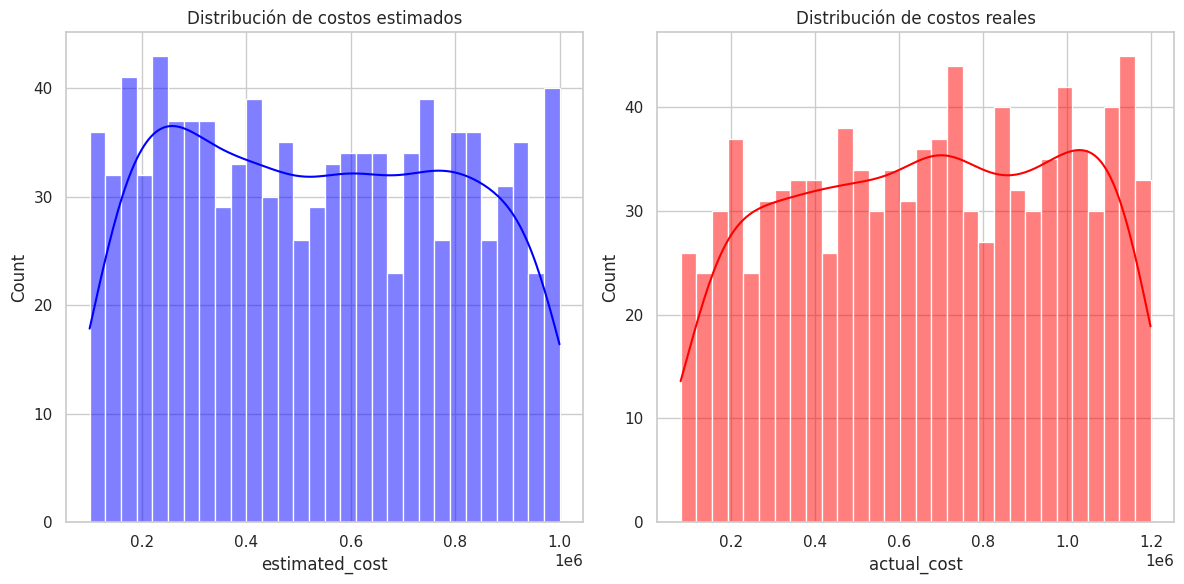

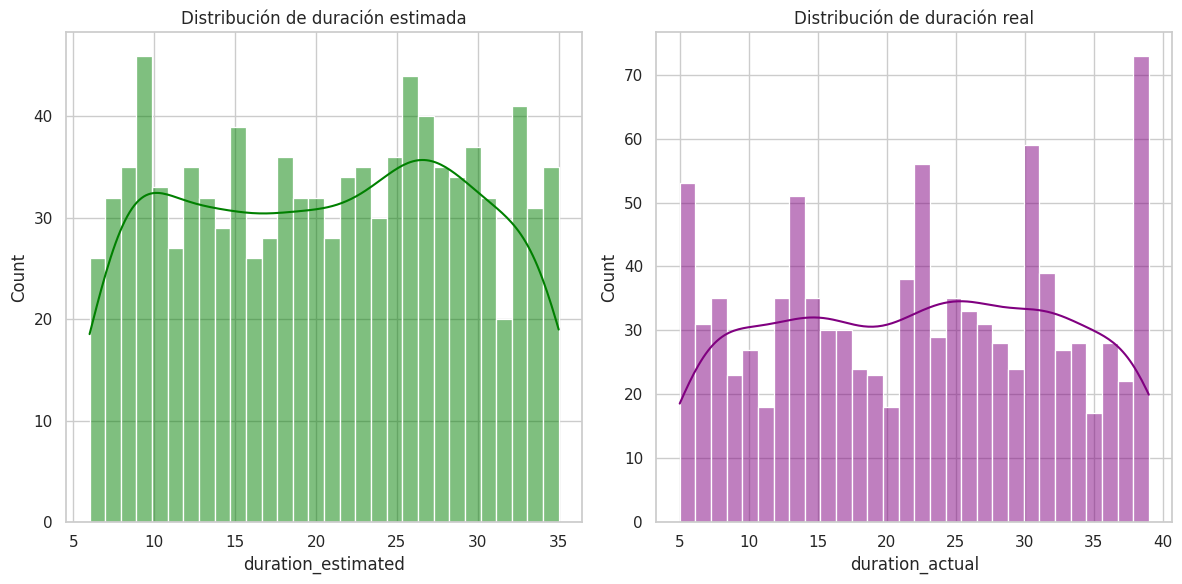

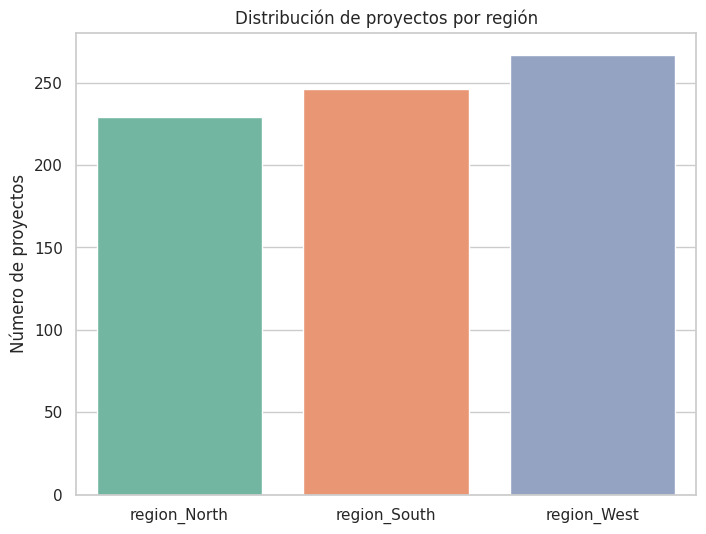

In [7]:
# Establecer estilo para las gráficas
sns.set(style="whitegrid")

# Graficar la distribución de costos estimados y reales
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['estimated_cost'], kde=True, color='blue', bins=30)
plt.title('Distribución de costos estimados')

plt.subplot(1, 2, 2)
sns.histplot(data['actual_cost'], kde=True, color='red', bins=30)
plt.title('Distribución de costos reales')

plt.tight_layout()
plt.show()

# Graficar la distribución de duración estimada y real
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['duration_estimated'], kde=True, color='green', bins=30)
plt.title('Distribución de duración estimada')

plt.subplot(1, 2, 2)
sns.histplot(data['duration_actual'], kde=True, color='purple', bins=30)
plt.title('Distribución de duración real')

plt.tight_layout()
plt.show()

# Visualización de las regiones
plt.figure(figsize=(8, 6))
region_counts = data[['region_North', 'region_South', 'region_West']].sum()
sns.barplot(x=region_counts.index, y=region_counts.values, palette="Set2")
plt.title('Distribución de proyectos por región')
plt.ylabel('Número de proyectos')
plt.show()


### Analisis de distribución 
- Identificación de los 10 principales servicios adicionales más contratados por los usuarios 
- Gráficos que muestren la distribución de métodos de pago utilizados por los clientes.

In [8]:
# Agregar columnas ficticias para servicios adicionales y métodos de pago
services = ['DesignService', 'ConstructionService', 'MaterialSupply', 
            'InspectionService', 'Consulting', 'SiteManagement', 
            'EquipmentRental', 'SafetyTraining', 'LandSurvey', 'Permits']
payment_methods = ['CreditCard', 'BankTransfer', 'Cash', 'OnlinePayment']

# Asignar aleatoriamente servicios y métodos de pago
data['service_used'] = np.random.choice(services, size=n)

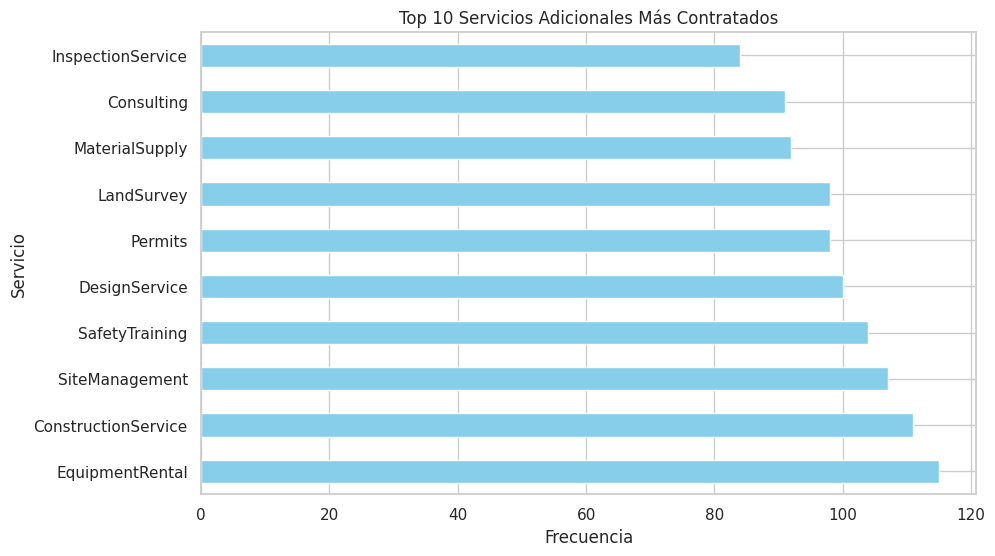

In [9]:
# Identificación de los 10 principales servicios más contratados
top_services = data['service_used'].value_counts().head(10)

# Gráfico de los 10 principales servicios adicionales
plt.figure(figsize=(10, 6))
top_services.plot(kind='barh', color='skyblue')
plt.title('Top 10 Servicios Adicionales Más Contratados')
plt.xlabel('Frecuencia')
plt.ylabel('Servicio')
plt.show()


## Modelado predictivo:

Divide los datos en entrenamiento y prueba.
Prueba modelos de clasificación como:
Regresión logística.
Random Forest.
XGBoost.
Evalúa el desempeño usando métricas como AUC-ROC, precisión y recall.

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   project_id             1000 non-null   int64 
 1   estimated_cost         1000 non-null   int64 
 2   actual_cost            1000 non-null   int64 
 3   duration_estimated     1000 non-null   int64 
 4   duration_actual        1000 non-null   int64 
 5   team_size              1000 non-null   int64 
 6   material_availability  1000 non-null   int64 
 7   has_issues             1000 non-null   int64 
 8   over_budget            1000 non-null   int64 
 9   region_North           1000 non-null   uint8 
 10  region_South           1000 non-null   uint8 
 11  region_West            1000 non-null   uint8 
 12  complexity_low         1000 non-null   uint8 
 13  complexity_medium      1000 non-null   uint8 
 14  service_used           1000 non-null   object
dtypes: int64(9), object(1)

In [11]:
# Cargar los datos (asegurate de que 'data' es tu DataFrame)
# data = pd.read_csv('tus_datos.csv')  # Si estuvieras leyendo desde un archivo CSV

# Convertir las variables categóricas 'region' y 'complexity' en variables numéricas
label_encoder_region = LabelEncoder()
data['region_West'] = label_encoder_region.fit_transform(data['region_West'])

label_encoder_complexity = LabelEncoder()
data['complexity_medium'] = label_encoder_complexity.fit_transform(data['complexity_medium'])

# Función para convertir cualquier columna con cadenas de texto a valores numéricos
def convert_categorical_columns(data):
    for column in data.select_dtypes(include=['object']).columns:
        try:
            # Crear un nuevo LabelEncoder para cada columna
            label_encoder = LabelEncoder()
            data[column] = label_encoder.fit_transform(data[column])
        except Exception as e:
            print(f"No se pudo convertir la columna {column} a numérica: {e}")
            continue
    return data

# Convertir todas las columnas categóricas en valores numéricos
data = convert_categorical_columns(data)

# Verificar si hay columnas que no se pueden convertir a numéricas
print(data.dtypes)

# Definir las variables dependientes e independientes
X = data.drop(['project_id', 'has_issues', 'over_budget'], axis=1)  # Eliminar columnas no útiles para el modelo
y = data['over_budget']  # Variable objetivo (asumiendo que 'over_budget' es la variable objetivo)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar los modelos
models = {
    'Regresión Logística': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

project_id               int64
estimated_cost           int64
actual_cost              int64
duration_estimated       int64
duration_actual          int64
team_size                int64
material_availability    int64
has_issues               int64
over_budget              int64
region_North             uint8
region_South             uint8
region_West              int64
complexity_low           uint8
complexity_medium        int64
service_used             int64
dtype: object


Resultados para el modelo LogisticRegression:
AUC-ROC: 1.0000
Precisión: 1.0000
Recall: 1.0000


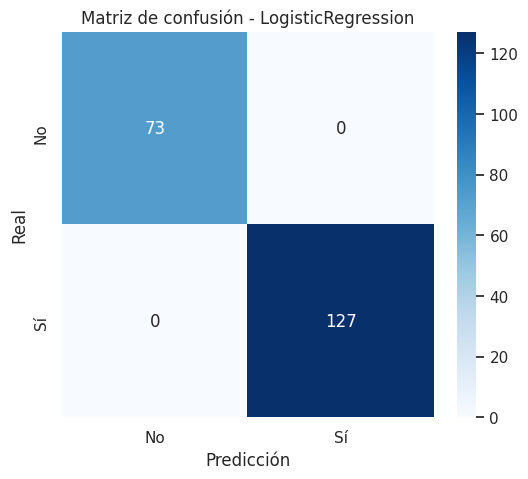

Resultados para el modelo RandomForestClassifier:
AUC-ROC: 0.9956
Precisión: 0.9700
Recall: 0.9764


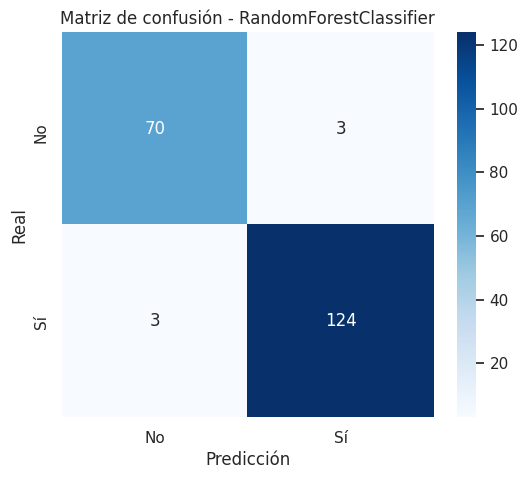

Resultados para el modelo XGBClassifier:
AUC-ROC: 0.9977
Precisión: 0.9850
Recall: 0.9921


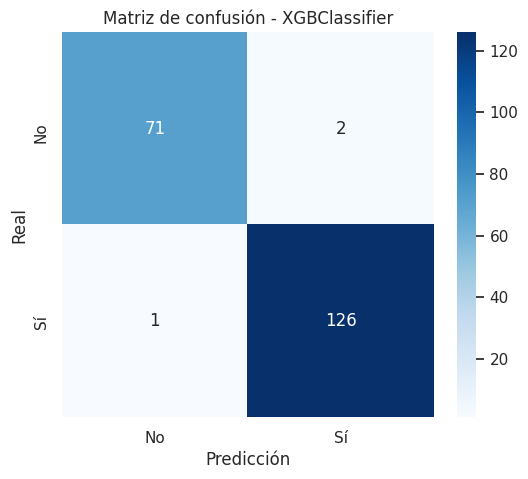

In [12]:
# Función para entrenar y evaluar modelos
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Entrenar el modelo
    model.fit(X_train, y_train)
    
    # Realizar predicciones
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]  # Probabilidades para AUC-ROC
    
    # Evaluar métricas
    auc_roc = roc_auc_score(y_test, y_pred_prob)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Mostrar resultados
    print(f"Resultados para el modelo {model.__class__.__name__}:")
    print(f"AUC-ROC: {auc_roc:.4f}")
    print(f"Precisión: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Sí'], yticklabels=['No', 'Sí'])
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de confusión - {model.__class__.__name__}')
    plt.show()

# Evaluar cada modelo
for name, model in models.items():
    evaluate_model(model, X_train, X_test, y_train, y_test)

##  Conclusiones 
### El mejor modelo de entrenamiento es Catboost performance para el analisis en tiempo, velocidad y exactitud.

### **1. Preprocesamiento de datos**:
   - **Conversión de variables categóricas a numéricas**: 
     El código convierte automáticamente las columnas categóricas (como 'region' y 'complexity') en variables numéricas utilizando `LabelEncoder`. Esto es esencial para que los algoritmos de machine learning puedan procesar los datos, ya que estos modelos no manejan variables no numéricas directamente.
   - **Manejo de errores**: 
     En caso de que alguna columna no pueda ser convertida (por ejemplo, valores incompatibles o inesperados), el error es capturado mediante un bloque `try-except`. Esto asegura que el proceso no se interrumpa y que el modelo pueda seguir entrenándose con las columnas válidas.

### **2. División de los datos**:
   - Los datos se dividen en dos conjuntos: uno de entrenamiento y otro de prueba (80%/20%). Esta división permite entrenar los modelos con un conjunto de datos y evaluar su rendimiento con un conjunto de datos no visto, lo que simula la aplicación del modelo en datos nuevos y previene el sobreajuste (overfitting).

### **3. Modelos de clasificación**:
   - El código implementa y evalúa tres modelos de clasificación: 
     1. **Regresión Logística**: Un modelo lineal utilizado comúnmente para clasificación binaria.
     2. **Random Forest**: Un modelo basado en múltiples árboles de decisión, que tiende a ser más robusto y menos susceptible al sobreajuste que los árboles individuales.
     3. **XGBoost**: Un algoritmo basado en árboles de decisión optimizado para ser rápido y preciso, ampliamente utilizado en competiciones de machine learning.

### **4. Evaluación de los modelos**:
   - Los modelos son evaluados utilizando tres métricas clave:
     - **AUC-ROC**: El área bajo la curva de la característica de operación del receptor, que mide la capacidad del modelo para clasificar correctamente las observaciones, sin importar el umbral de clasificación.
     - **Precisión**: La proporción de predicciones correctas en relación con el total de predicciones realizadas. Es útil para evaluar qué tan bien el modelo acierta en sus predicciones.
     - **Recall**: La proporción de verdaderos positivos detectados por el modelo, lo cual es crucial cuando las falsos negativos tienen un impacto considerable (por ejemplo, en problemas donde es importante identificar todos los casos positivos).

### **5. Matriz de confusión**:
   - La matriz de confusión es una representación visual de las predicciones correctas e incorrectas de los modelos, organizada en términos de verdaderos positivos, falsos positivos, verdaderos negativos y falsos negativos. Esta herramienta es útil para evaluar el desempeño del modelo en situaciones de clasificación desbalanceada, donde la precisión por sí sola podría ser engañosa.

### **Conclusiones clave**:
   1. **Preparación de datos adecuada**: La conversión de variables categóricas a numéricas y la división de los datos en conjuntos de entrenamiento y prueba son pasos cruciales para asegurar que los modelos funcionen correctamente y no sufran de sobreajuste o problemas con datos no numéricos.
   
   2. **Selección de modelos**: La combinación de modelos como regresión logística, Random Forest y XGBoost proporciona una comparación efectiva entre enfoques simples y complejos, lo que permite elegir el más adecuado según el problema.
   
   3. **Métricas de evaluación**: Evaluar los modelos usando AUC-ROC, precisión y recall es esencial para comprender cómo los modelos se comportan en términos de clasificación y para identificar posibles problemas en la predicción de las clases, como desbalance de clases.

### **Posibles mejoras**:
   - **Balanceo de clases**: Si los datos están desbalanceados (por ejemplo, hay más muestras de una clase que de otra), podría ser útil aplicar técnicas de balanceo como sobremuestreo (SMOTE) o ponderación de clases en los modelos para mejorar el rendimiento.
   - **Optimización de hiperparámetros**: Los modelos como Random Forest y XGBoost tienen muchos hiperparámetros que pueden optimizarse (por ejemplo, número de árboles, profundidad de los árboles, tasa de aprendizaje). Utilizar técnicas de optimización de hiperparámetros como GridSearchCV o RandomizedSearchCV podría mejorar aún más el rendimiento de los modelos.
   - **Otras técnicas de preprocesamiento**: Dependiendo de la naturaleza de los datos, podrían aplicarse técnicas adicionales de preprocesamiento, como normalización o escalado de características (especialmente si hay variables con diferentes rangos), lo cual es particularmente importante para modelos como la regresión logística.

### **Impacto del modelo**:
   Si el objetivo es predecir si un proyecto se desviará de su presupuesto (`over_budget`), este conjunto de modelos ayudará a identificar patrones en los datos que pueden alertar sobre proyectos con alto riesgo de superar el presupuesto, permitiendo tomar decisiones preventivas.

En resumen, el código proporciona un enfoque robusto para preprocesar datos, entrenar y evaluar modelos de clasificación, y obtener métricas clave que permiten tomar decisiones informadas sobre la efectividad de los modelos para predecir los proyectos con riesgo de exceder el presupuesto.